# Project 2 TAA

## Expression Recognition with Keras

### Load datasets from file

In [28]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#to load matlab mat files
from scipy.io import loadmat
# for neural network
import tensorflow as tf
from tensorflow import keras

# Kfold
from sklearn.model_selection import KFold

# Show images
from PIL import Image
import os

In [52]:
labelNames = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']

# Load Training data cropped
mat=loadmat(f"./datasets/crop/train/{'_'.join(labelNames)}.mat")
# mat is a dict with key "X" for x-values, and key "y" for y values
X_crop, y_crop = np.expand_dims(mat["X"], -1), mat["y"]

# Load Training data not cropped
mat=loadmat(f"./datasets/no_crop/train/{'_'.join(labelNames)}.mat")
# mat is a dict with key "X" for x-values, and key "y" for y values
X_nocrop, y_nocrop = np.reshape(mat["X"],(mat["X"].shape[0],mat["X"].shape[1],mat["X"].shape[2],1)), mat["y"]




# Load Test data cropped
mat=loadmat(f"./datasets/crop/test/{'_'.join(labelNames)}.mat")
# mat is a dict with key "X" for x-values, and key "y" for y values
X_crop_test, y_crop_test = np.reshape(mat["X"],(mat["X"].shape[0],mat["X"].shape[1],mat["X"].shape[2],1)), mat["y"]

# Load test data not cropped
mat=loadmat(f"./datasets/no_crop/test/{'_'.join(labelNames)}.mat")
# mat is a dict with key "X" for x-values, and key "y" for y values
X_nocrop_test, y_nocrop_test = np.reshape(mat["X"],(mat["X"].shape[0],mat["X"].shape[1],mat["X"].shape[2],1)), mat["y"]


In [54]:
# numbers
m_crop = X_crop.shape[0] # number of training examples
m_nocrop = X_nocrop.shape[0]
labels = np.max(y_crop)+1 # number of labels
features = X_crop.shape[1:] # number of features per example

print(f"Loaded {m_crop} traing examples cropped and {m_nocrop} no cropped with {labels} labels ({int(m_crop/labels)} for each), each with {features} features (pixels).")
print("Labels are:", ', '.join(labelNames))

print(f"Loaded {X_crop.shape[0]} dev examples.")

print("X_crop.shape", X_crop.shape)

Loaded 9600 traing examples cropped and 9600 no cropped with 8 labels (1200 for each), each with (48, 48, 1) features (pixels).
Labels are: Neutral, Happy, Sad, Surprise, Fear, Disgust, Anger, Contempt
Loaded 9600 dev examples.
X_crop.shape (9600, 48, 48, 1)


### Some examples

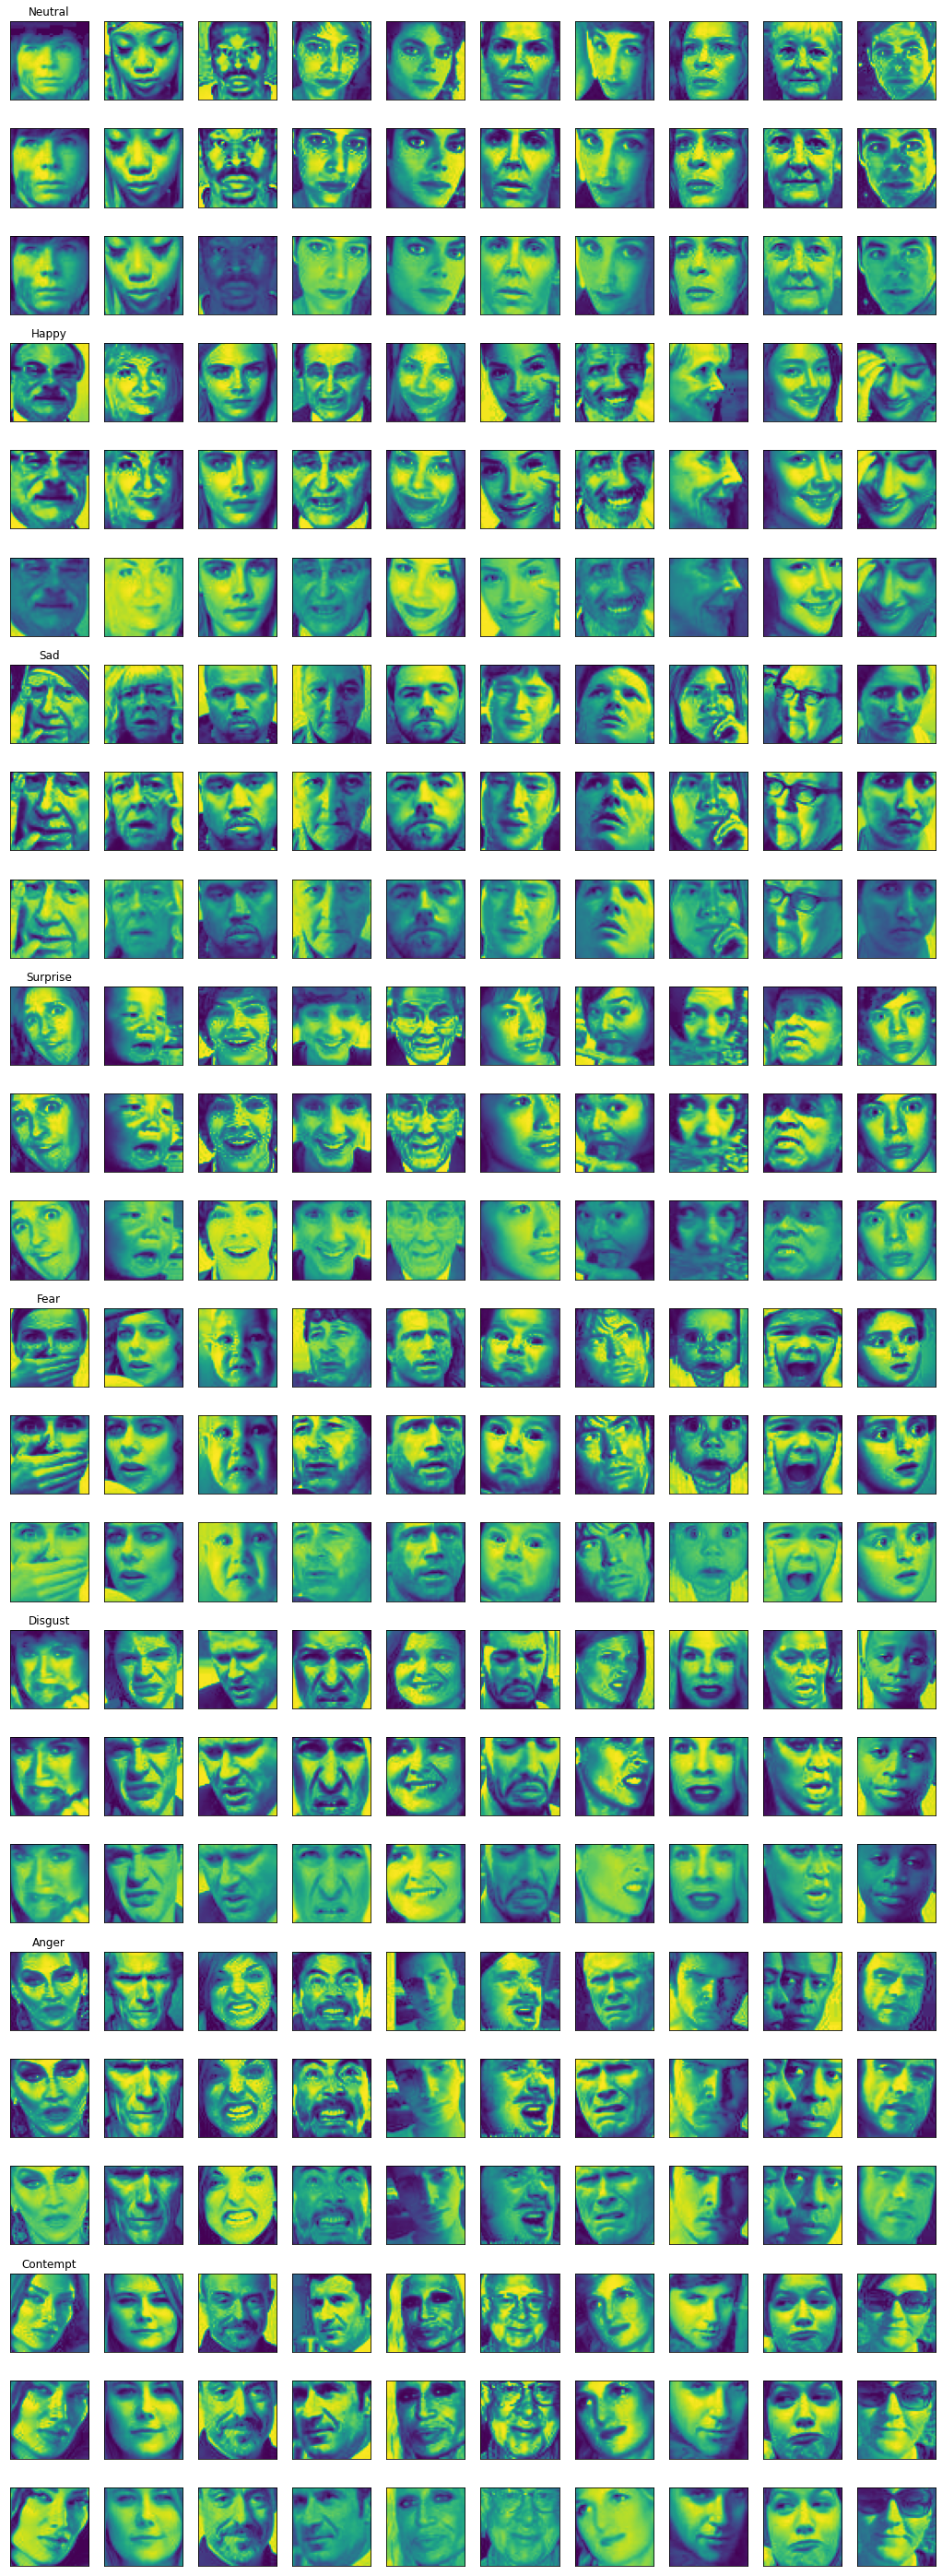

In [31]:
examplesNumber = 10
fig, axis = plt.subplots(labels*3,examplesNumber,figsize=(18,5.5*labels))
fig.subplots_adjust(top=1)

# Foreach label, output 10 random images
for i in range(0, labels*3, 3):
    
    entries_cropped = list(filter(lambda y: '_face' in y, sorted(os.listdir('./data/train_set/processed/' + labelNames[i//3]), key=lambda x:int(x.split('.')[0].split('_')[0]))))
    
    for j in range(0, 10):
        # Show image
        axis[i,j].imshow(X_nocrop[int((m_nocrop/labels)*(i//3)+j),:])
        axis[i+1,j].imshow(X_crop[int((m_crop/labels)*(i//3)+j),:])
        axis[i+2,j].imshow(Image.open('./data/train_set/processed/' + labelNames[i//3] + '/' + entries_cropped[j]).convert('L'))
        # Hide axes
        axis[i,j].set_xticks([])
        axis[i,j].set_yticks([])
        axis[i+1,j].set_xticks([])
        axis[i+1,j].set_yticks([])
        axis[i+2,j].set_xticks([])
        axis[i+2,j].set_yticks([])
        # Display title only on first
        if j==0:
            axis[i,j].set_title(labelNames[i//3])

In [46]:
def create_model(num_features,num_labels):
    model = keras.models.Sequential()

    model.add(keras.layers.Conv2D(num_features, (3, 3), activation='relu', input_shape=[48, 48, 1]))
    model.add(keras.layers.Conv2D(num_features, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))


    model.add(keras.layers.Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))


    model.add(keras.layers.Conv2D(num_features, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(num_features, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))


    model.add(keras.layers.Conv2D(num_features, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(num_features, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))


    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(num_features, activation='relu'))
    model.add(keras.layers.Dense(num_labels, activation='softmax'))

    model.summary()
    return model

In [47]:
#model.compile(loss = "sparse_categorical_crossentropy", optimizer = "sgd",metrics = ["accuracy"])                 

In [56]:
kFold = KFold()

for train, test in kFold.split(X_crop, y_crop):
    print("train", train)
    print("test", test)
   
    print(X_crop.shape)
    model= create_model(64,8)

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    history = model.fit(X_crop[train], y_crop[train], epochs = 10, validation_data=(X_crop[test], y_crop[test]))
    scores = model.evaluate(X_crop[test], y_crop[test])
    
    break

train [1920 1921 1922 ... 9597 9598 9599]
test [   0    1    2 ... 1917 1918 1919]
(9600, 48, 48, 1)
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_136 (Conv2D)          (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_119 (Bat (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 23, 23, 64)        36928     
_________________________________________________________________
batch_normalization_120 (Bat (None, 23, 23, 64)        256       
__________________

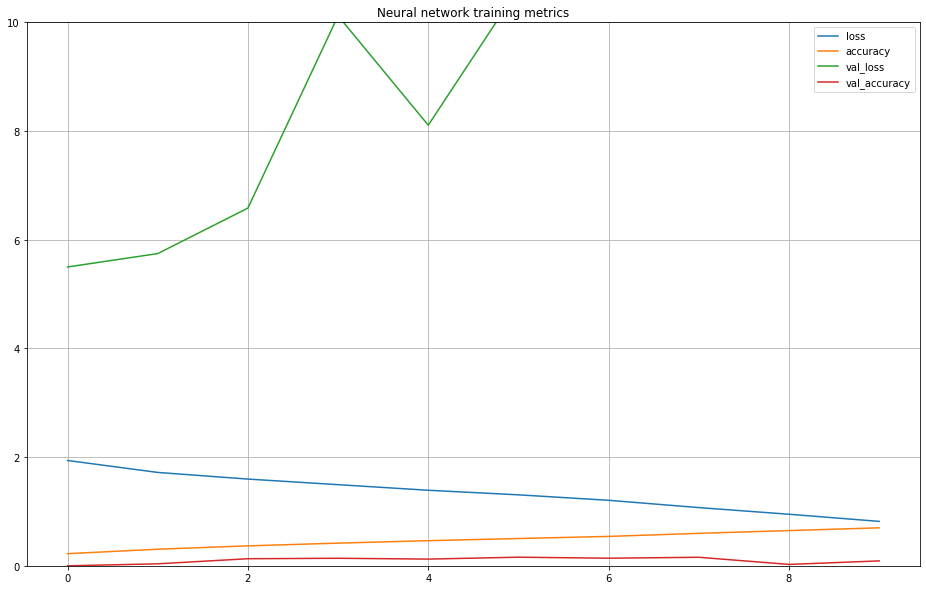

In [59]:
pd.DataFrame(history.history).plot(figsize = (16, 10))
plt.grid(True)
plt.gca().set_ylim(0, 10)
plt.title("Neural network training metrics")
plt.show()

In [58]:
scores = model.evaluate(X_crop_test, y_crop_test)

39/50 [======================>.......] - ETA: 0s - loss: 4.9637 - accuracy: 0.3053

KeyboardInterrupt: 

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 46, 46, 48)        480       
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 46, 46, 48)        20784     
_________________________________________________________________
batch_normalization_77 (Batc (None, 46, 46, 48)        192       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 23, 23, 48)        0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 23, 23, 48)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 23, 23, 96)        41568     
_________________________________________________________________
batch_normalization_78 (Batc (None, 23, 23, 96)      

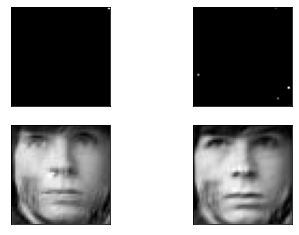

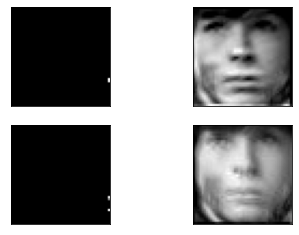

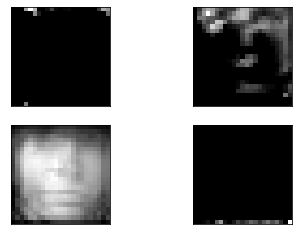

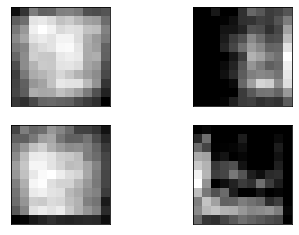

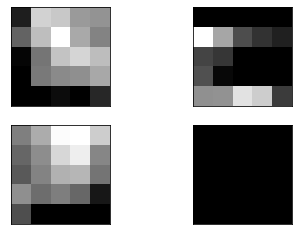

In [40]:
model = create_model(48,8)
model.summary()
# redefine model to output right after the first hidden layer
ixs = [0,1,7,13,19]
outputs = [model.layers[i].output for i in ixs]
model = keras.models.Model(inputs=model.inputs, outputs=outputs)

# get feature map for first hidden layer
feature_maps = model.predict(np.expand_dims(X_crop[0,:],axis=0))
# plot the output from each block
square = 2
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    plt.show()